In [ ]:
import pydicom
from matplotlib import pyplot as plt


3056 2544


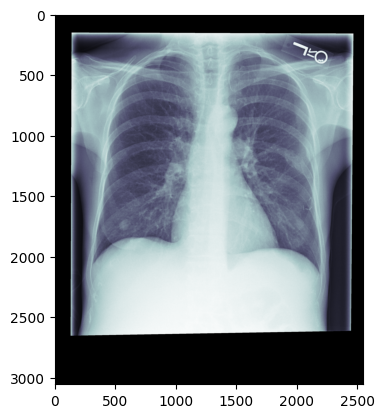

In [7]:
# load dcm
image = pydicom.dcmread("data/02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.dcm")
# print length, width of pixel array
print(len(image.pixel_array), len(image.pixel_array[0]))
# show image content
plt.imshow(image.pixel_array, cmap=plt.cm.bone)


In [9]:
# pip install torch torchvision timm pydicom pillow scikit-learn
import pydicom
import numpy as np
import torch, torch.nn as nn
import torchvision.transforms as T
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

try:
    import timm
    HAS_TIMM = True
except Exception:
    HAS_TIMM = False

# -----------------------------
# 0) DICOM → normalized 3-channel tensor
# -----------------------------
def dicom_to_rgb_tensor(ds: pydicom.dataset.FileDataset, target_size=1024):
    px = ds.pixel_array.astype(np.float32)

    # Apply DICOM rescale if present
    slope = float(getattr(ds, "RescaleSlope", 1.0))
    intercept = float(getattr(ds, "RescaleIntercept", 0.0))
    px = px * slope + intercept

    # Windowing if tags exist, else min-max
    if hasattr(ds, "WindowCenter") and hasattr(ds, "WindowWidth"):
        # WC/WW can be sequences
        wc = float(np.atleast_1d(ds.WindowCenter)[0])
        ww = float(np.atleast_1d(ds.WindowWidth)[0])
        lo, hi = wc - ww / 2.0, wc + ww / 2.0
        px = np.clip(px, lo, hi)
    else:
        lo, hi = np.percentile(px, 0.5), np.percentile(px, 99.5)
        px = np.clip(px, lo, hi)

    # Normalize to [0,1]
    px = (px - px.min()) / (px.max() - px.min() + 1e-8)

    # To PIL for transforms
    import PIL.Image as Image
    H, W = px.shape
    pil = Image.fromarray(np.uint8(px * 255), mode="L").convert("RGB")  # repeat to 3-ch

    tfm = T.Compose([
        T.Resize(target_size, interpolation=T.InterpolationMode.BICUBIC),
        T.CenterCrop(target_size),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats for most encoders
                    std=[0.229, 0.224, 0.225]),
    ])
    tensor = tfm(pil).unsqueeze(0)  # [1,3,H,W]
    return tensor, np.array(pil)

# -----------------------------
# 1) Build an encoder and register hooks
# -----------------------------
class FeatureTap:
    def __init__(self):
        self.outputs = {}
        self.handles = []

    def hook(self, name):
        def fn(module, inp, out):
            self.outputs[name] = out.detach()
        return fn

    def register(self, model, layers):
        for name, layer in layers:
            self.handles.append(layer.register_forward_hook(self.hook(name)))

    def clear(self):
        for h in self.handles:
            h.remove()
        self.outputs.clear()

def build_encoder(kind="vit"):
    if kind == "vit" and HAS_TIMM:
        # ViT that accepts arbitrary size; change to your checkpoint if needed
        model = timm.create_model("vit_base_patch16_224", pretrained=True)
        model.eval()
        # Pick a few transformer blocks to tap
        layers = [(f"block{i}", model.blocks[i]) for i in [3, 6, 9, 11]]
        tap = FeatureTap()
        tap.register(model, layers)
        return model, tap, {"type": "vit", "patch": 16}
    else:
        # Fallback: ResNet50 from torchvision
        from torchvision.models import resnet50, ResNet50_Weights
        model = resnet50(weights=ResNet50_Weights.DEFAULT)
        model.eval()
        # Tap C2, C3, C4, C5 stages
        layers = [("layer1", model.layer1),
                  ("layer2", model.layer2),
                  ("layer3", model.layer3),
                  ("layer4", model.layer4)]
        tap = FeatureTap()
        tap.register(model, layers)
        return model, tap, {"type": "resnet"}

# -----------------------------
# 2) Helpers to turn features into 2D maps
# -----------------------------
def vit_tokens_to_map(feat_tokens, patch=16, img_size=1024):
    """
    feat_tokens: [B, N, C] from a ViT block output (token sequence after block)
    returns [H', W', C] spatial map by dropping CLS and reshaping.
    """
    B, N, C = feat_tokens.shape
    # first token is CLS for timm ViTs
    grid_tokens = feat_tokens[:, 1:, :]  # [B, H'*W', C]
    h = w = int(np.sqrt(grid_tokens.shape[1]))
    fmap = grid_tokens.reshape(B, h, w, C).squeeze(0)  # [h, w, C]
    # Upsample to image size for visualization
    fmap = torch.from_numpy(fmap.cpu().numpy()) if isinstance(fmap, np.ndarray) else fmap
    fmap = fmap.permute(2, 0, 1).unsqueeze(0)  # [1,C,h,w]
    fmap_up = torch.nn.functional.interpolate(fmap, size=(img_size, img_size), mode="bilinear", align_corners=False)
    return fmap_up.squeeze(0).permute(1, 2, 0).cpu().numpy()  # [H,W,C]

def cnn_to_map(feat_tensor, img_size=1024):
    """
    feat_tensor: [B, C, h, w] from a CNN stage
    returns upsampled [H, W, C]
    """
    fmap = torch.nn.functional.interpolate(feat_tensor, size=(img_size, img_size),
                                           mode="bilinear", align_corners=False)
    return fmap.squeeze(0).permute(1, 2, 0).cpu().numpy()

def pca_project(fmap_hw_c, n_components=3):
    """
    fmap_hw_c: [H, W, C] → return list of n_components heatmaps in [0,1]
    """
    H, W, C = fmap_hw_c.shape
    X = fmap_hw_c.reshape(-1, C)
    # Normalize per-channel
    X = (X - X.mean(0, keepdims=True)) / (X.std(0, keepdims=True) + 1e-6)
    p = PCA(n_components=n_components, svd_solver="randomized", whiten=False)
    comps = p.fit_transform(X)  # [H*W, k]
    comps = comps.reshape(H, W, n_components)
    # min-max each component for display
    comps_disp = []
    for i in range(n_components):
        m = comps[..., i]
        m = (m - m.min()) / (m.max() - m.min() + 1e-8)
        comps_disp.append(m)
    return comps_disp  # list of [H,W]

def show_overlays(rgb8, heatmaps, titles, alpha=0.45, cmap="viridis"):
    """
    rgb8: uint8 HxWx3 X-ray image used as background
    heatmaps: list of [H,W] floats in [0,1]
    """
    n = len(heatmaps)
    plt.figure(figsize=(4*n, 4))
    for i, m in enumerate(heatmaps):
        plt.subplot(1, n, i+1)
        plt.imshow(rgb8)
        plt.imshow(m, cmap=cmap, alpha=alpha, interpolation="nearest")
        plt.axis("off")
        plt.title(titles[i])
    plt.tight_layout()
    plt.show()

# -----------------------------
# 3) End-to-end demo
# -----------------------------
# You already have:
# image = pydicom.dcmread("data/02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.dcm")

# Prepare input
img_tensor, rgb_vis = dicom_to_rgb_tensor(image, target_size=1024)  # img_tensor [1,3,1024,1024]

# Choose and build an encoder
model, tap, meta = build_encoder(kind="vit" if HAS_TIMM else "resnet")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
img_tensor = img_tensor.to(device)

# Forward pass to populate hooks
with torch.no_grad():
    _ = model(img_tensor)

# Visualize one or two tapped layers
to_show = []
titles = []
if meta["type"] == "vit":
    for name, feat in tap.outputs.items():
        # ViT block output is usually token sequence [B,N,C]
        feat_tokens = feat  # [1,N,C]
        fmap = vit_tokens_to_map(feat_tokens.cpu(), patch=meta.get("patch", 16), img_size=rgb_vis.shape[0])
        pcs = pca_project(fmap, n_components=3)  # three principal components
        to_show.extend(pcs[:2])                  # show two PCs per layer for brevity
        titles.extend([f"{name} PC1", f"{name} PC2"])
        if len(to_show) >= 6:
            break
else:
    for name, feat in tap.outputs.items():
        fmap = cnn_to_map(feat.cpu(), img_size=rgb_vis.shape[0])  # [H,W,C]
        pcs = pca_project(fmap, n_components=2)
        to_show.extend(pcs)
        titles.extend([f"{name} PC1", f"{name} PC2"])
        if len(to_show) >= 6:
            break

show_overlays(rgb_vis, to_show, titles, alpha=0.5)


/var/folders/7_/yw7l4yh94gxbn8trq0g3vhsw0000gn/T/ipykernel_96902/2401685294.py:43: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil = Image.fromarray(np.uint8(px * 255), mode="L").convert("RGB")  # repeat to 3-ch


KeyboardInterrupt: 